# Real Estate Prices Prediction

## Project Scoping

*Can we build a model to better predict transaction prices of real estate prices?*

### Specifics

1. Deliverable: Trained model file
2. Machine Learning Task: Regression
3. Target Variable: Transaction Price
4. Input Features: 22 independent variable including `Public records for the property`, `Property characteristics`, `Location convenience scores`, `Neighborhood demographics`, `Schools`
5. Win Condition: Mean Absolute Error (MAE) < $70,000

### Outline

1. Load packages and read data
2. Data Summary
3. Exploratory Data Analysis
4. Data Cleaning
5. Feature Engineering and Preprocessing
6. Model Development
7. Model Selection
8. References

## Load libraries and data

In [46]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [104]:
### import the libraries

# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100) # expands the maximum number of columns Pandas is allowed

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# Import ML models from scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Function for model selection, pipeline building, preprocessing, cv, and metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [105]:
%watermark -a 'Yama Chang' -d -t -v -p pandas,numpy,sklearn,watermark

Author: Yama Chang

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0

pandas   : 1.5.3
numpy    : 1.23.5
sklearn  : 1.2.1
watermark: 2.4.3



In [106]:
### import the cleaned dataset

# Load real estate data from CSV
df = pd.read_csv('./data/analytical_base_table.csv')

# Success
print("REIT ABT has {} data points with {} variables each.".format(*df.shape))

REIT ABT has 1863 data points with 40 variables each.


## Model Development

First, we want to split out separate training and test subsets of our dataset, and create target variable (y) and input feature (x)

In [107]:
# Create separate object for target variable/features
y = df.tx_price
x = df.drop('tx_price', axis=1)

In [108]:
# split out separate training and test subsets of our dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                   test_size=0.2,
                                                   random_state=1234)

# check length of each df
print( len(x_train), len(x_test), len(y_train), len(y_test) )

1490 373 1490 373


### 1. Preprocessing & Pipelines

We want to preprocess the data by transforming the data into a format that will be more suitable for the model. Here, we may want to do standardization. Additionally, we want to first import the pipeline tool, and then import the preprocessing techniques we want to use.

In [109]:
# Create pipelines dictionary
pipelines = {
    'lasso' : make_pipeline(StandardScaler(), Lasso(random_state=123)),
    'ridge' : make_pipeline(StandardScaler(), Ridge(random_state=123)),
    'enet'  : make_pipeline(StandardScaler(), ElasticNet(random_state=123)),
    'rf' : make_pipeline(StandardScaler(), RandomForestRegressor(random_state=123)),
    'gb' : make_pipeline(StandardScaler(), GradientBoostingRegressor(random_state=123))
}

In [110]:
# Check
pipelines['lasso'].get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('lasso', Lasso(random_state=123))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'lasso': Lasso(random_state=123),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 123,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

### 2. Tuning Hyperparameters

In [111]:
# Declare hyperparameters to tune
# Lasso hyperparameter grid
lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10] 
}


# Ridge hyperparameter grid
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]  
}

# Elastic Net hyperparameter grid
enet_hyperparameters = {
    'elasticnet__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'elasticnet__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]  
}

# Random Forest hyperparameter grid
rf_hyperparameters = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_features': ['auto', 'sqrt', 0.33]
}

# Gradient Boosting Tree hyperparameter grid
gb_hyperparameters = {
    'gradientboostingregressor__n_estimators': [100, 200],
    'gradientboostingregressor__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingregressor__max_depth': [1, 3, 5]
}

In [112]:
# Create hyperparameters dictionary
hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters,
    'enet' : enet_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

In [113]:
# Check hyperparameters keys
hyperparameters.keys()
pipelines.keys()

dict_keys(['lasso', 'ridge', 'enet', 'rf', 'gb'])

In [114]:
# Check that hyperparameters is set up correctly
for key in ['enet', 'gb', 'ridge', 'rf', 'lasso']:
    if key in hyperparameters:
        if type(hyperparameters[key]) is dict:
            print( key, 'was found in hyperparameters, and it is a grid.' )
        else:
            print( key, 'was found in hyperparameters, but it is not a grid.' )
    else:
        print( key, 'was not found in hyperparameters')

enet was found in hyperparameters, and it is a grid.
gb was found in hyperparameters, and it is a grid.
ridge was found in hyperparameters, and it is a grid.
rf was found in hyperparameters, and it is a grid.
lasso was found in hyperparameters, and it is a grid.


### 3. Fit and tune models

In [115]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on x_train, y_train
    model.fit(x_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.265e+12, tolerance: 3.171e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.669e+12, tolerance: 3.184e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.911e+11, tolerance: 3.184e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e+12, tolerance: 3.178e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

lasso has been fitted.
ridge has been fitted.


/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.577e+12, tolerance: 3.171e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.463e+12, tolerance: 3.184e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.557e+12, tolerance: 3.171e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.675e+12, tolerance: 3.188e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.519e+12, tolerance: 3.117e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.592e+12, tolerance: 3.199e+09
  model = cd_fast.enet_coordinate_descent(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularis

enet has been fitted.


/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is a

rf has been fitted.
gb has been fitted.


In [116]:
# Check that the models are of the correct type
for key, value in fitted_models.items():
    print( key, type(value) ) # Okie!

lasso <class 'sklearn.model_selection._search.GridSearchCV'>
ridge <class 'sklearn.model_selection._search.GridSearchCV'>
enet <class 'sklearn.model_selection._search.GridSearchCV'>
rf <class 'sklearn.model_selection._search.GridSearchCV'>
gb <class 'sklearn.model_selection._search.GridSearchCV'>


In [117]:
# Check that the models have been fitted correctly
from sklearn.exceptions import NotFittedError

for name, model in fitted_models.items():
    try:
        pred = model.predict(x_test)
        print(name, 'has been fitted.')
    except NotFittedError as e:
        print(repr(e))

lasso has been fitted.
ridge has been fitted.
enet has been fitted.
rf has been fitted.
gb has been fitted.


## Model Selection

In [118]:
# Display the cross-validated training performance for each model
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso 0.30862751396391264
ridge 0.3166111585985651
enet 0.3428746288316883
rf 0.4811321119157224
gb 0.4876576401149557


In [119]:
# Fit the test set using fitted models
# Print the performance of each model in fitted_models on the test set

for name, model in fitted_models.items():
    # Predict test set using fitted lasso
    pred = fitted_models[name].predict(x_test)
    
    print( name )
    print( '--------' )
    print( 'R^2:', r2_score(y_test, pred) )
    print( 'MAE:', mean_absolute_error(y_test, pred) )
    print( '')    

lasso
--------
R^2: 0.40888624694383724
MAE: 85035.54249916306

ridge
--------
R^2: 0.4093396476329719
MAE: 84978.03564808937

enet
--------
R^2: 0.40524513747655944
MAE: 86298.63724146318

rf
--------
R^2: 0.5692239323323502
MAE: 68274.08348525468

gb
--------
R^2: 0.5396899984684429
MAE: 70621.43433472609



In [120]:
# Let's create a data frame to display our metrics
results_df = pd.DataFrame(columns=['Model', 'MAE', 'R2 Square'])  # Initialize an empty DataFrame

for name, model in fitted_models.items():
    # Predict test set using fitted lasso
    pred = fitted_models[name].predict(x_test)
    
    model_results = pd.DataFrame(data=[[name, round(mean_absolute_error(y_test, pred), 2), round(r2_score(y_test, pred), 2)]],
                                 columns=['Model', 'MAE', 'R2 Square'])
    
    results_df = results_df.append(model_results, ignore_index=True)  # Append results to the DataFrame

results_df  # Display the final DataFrame


/var/folders/d3/9ly5k4s50pn98c5j4xljd3h00000gn/T/ipykernel_30709/303705425.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(model_results, ignore_index=True)  # Append results to the DataFrame
/var/folders/d3/9ly5k4s50pn98c5j4xljd3h00000gn/T/ipykernel_30709/303705425.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(model_results, ignore_index=True)  # Append results to the DataFrame
/var/folders/d3/9ly5k4s50pn98c5j4xljd3h00000gn/T/ipykernel_30709/303705425.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(model_results, ignore_index=True)  # Append results to the DataFrame
/var/folders/d3/9ly5k4s50pn98c5j4xljd3h00000gn/T/

,Model,MAE,R2 Square
0,lasso,85035.54,0.41
1,ridge,84978.04,0.41
2,enet,86298.64,0.41
3,rf,68274.08,0.57
4,gb,70621.43,0.54


From reading the metrics, we can see that Random Forest has the **highest R2** and **lowest MAE**. Although Gradient Boosting Tree shows the best holdout R2 score from cross-validation, Random Forest is just slightly lower than it. Most importantly, RF satisfy our porject's win condition (lower than $70K). 

Finally, let's plot the performance of the winning model on the test set.

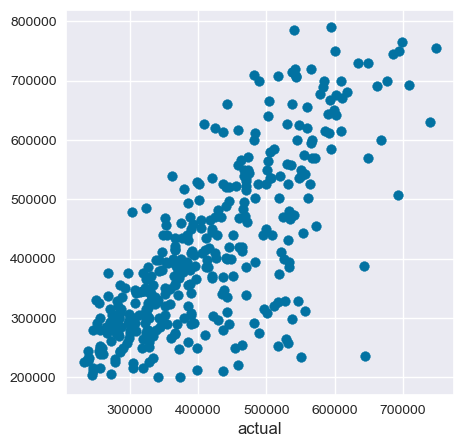

In [121]:
# Grab our winning model
rf_pred = fitted_models['rf'].predict(x_test)
# plot a scatter plot!
plt.figure(figsize=(5,5))
plt.scatter(rf_pred, y_test)
plt.xlabel('predicted')
plt.xlabel('actual')
plt.show()

## Save our winning model

In [122]:
type(fitted_models['rf'])

sklearn.model_selection._search.GridSearchCV

In [123]:
type( fitted_models['rf'].best_estimator_ )

sklearn.pipeline.Pipeline

In [124]:
fitted_models['rf'].best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='auto', n_estimators=200,
                                       random_state=123))])

We can see from the pipeline that, the winning values for our hyperparameters are:

* `n_estimators`: 200
* `max_features` : 'auto'

In [125]:
# Save our winning model
import pickle
with open('final_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)

### Plot the winning model 

In [172]:
# Create a residual plot for Random Forest model.
from yellowbrick.regressor import residuals_plot

# Instantiate the linear model and visualizer 
# Create your custom title
my_title = "Residuals for Random Forest Model"

# viz = residuals_plot(fitted_models['rf'], x_train, y_train, x_test, y_test, title=my_title) 
# model = Ridge()

visualizer = ResidualsPlot(fitted_models['rf'], title=my_title)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data 
g = visualizer.show(outpath="residuals_rf_model.png", clear_figure=True, dpi=300)    # Finalize and render the visualizer

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<Figure size 800x550 with 0 Axes>

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


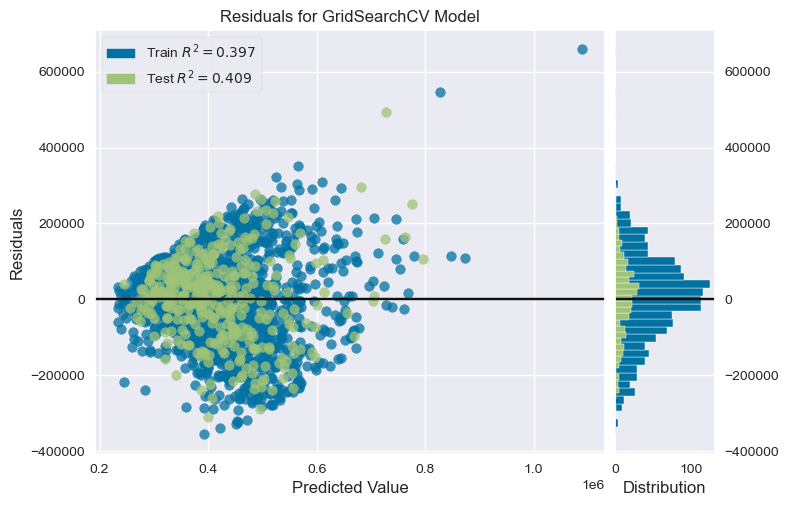

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


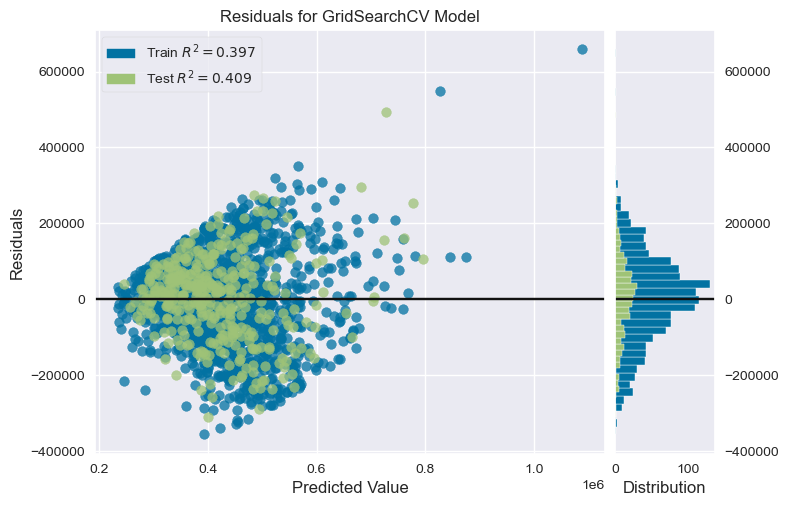

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


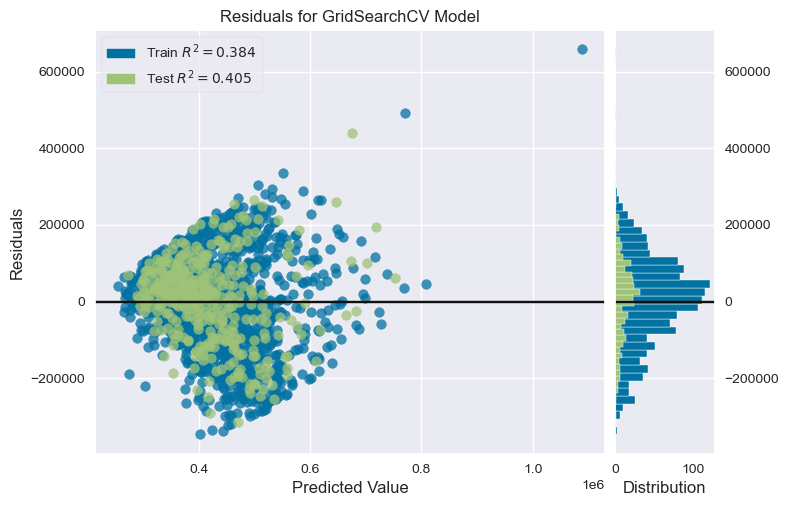

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


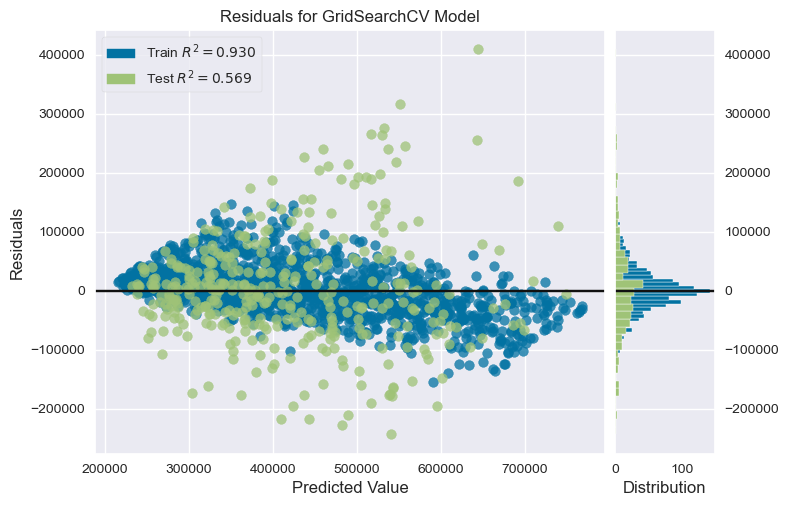

/Users/yamachang/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


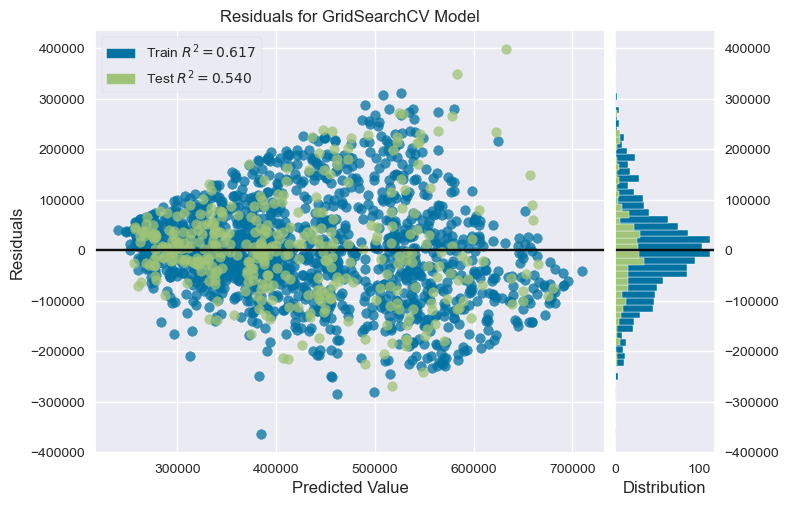

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'GridSearchCV' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'GridSearchCV' have attribute 'line_color'

YellowbrickAttributeError: neither visualizer 'ResidualsPlot' nor wrapped estimator 'GridSearchCV' have attribute 'line_color'

In [130]:
#for name, model in fitted_models.items():
    
#    viz = residuals_plot(fitted_models[name], x_train, y_train, x_test, y_test) 

#viz # Display the final DataFrame


## References

* [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* [What is random forest?](https://www.ibm.com/topics/random-forest)